In [29]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import minimize

Im trying to see how cardinality affects total variation distance for two random probabilities on finite sets

# Totally random case
where $\alpha = 1$

We define $p_1 \sim Dirichlet((1, ..., 1))$ and $p_2 \sim Dirichlet((1, ..., 1))$ and then compute $TV(p_1, p_2)$ to get some statistics

In [200]:
def calc_tv(p1, p2):
    return abs(p1 - p2).sum(axis=1)

def sample_two_dir(card, samples):
    return np.random.dirichlet(np.ones(card), size=(2, samples))

def sample_tv(card, samples, tv_func, kind='uniform'):
    if kind == "uniform":
        dir_samples = np.random.dirichlet(np.ones(card), size=(2, samples))
    else:
        pass
    p1, p2 = dir_samples[0], dir_samples[1]
    return tv_func(p1, p2)

def estimate_prob(card, thresh, tv_func, kind='uniform',):
    tv_samples = sample_tv(card, samples, tv_func, kind)
    return (tv_samples >= thresh).mean()

def estimate_mean(card, tv_func, kind='uniform'):
    tv_samples = sample_tv(card, samples, tv_func, kind)
    return tv_samples.mean() 

In [223]:
card_range = np.arange(2, 100, dtype=int)
samples = 1_000_000
thresh = 1.5

prob_series = pd.Series({card: estimate_prob(card, thresh, calc_tv) for card in card_range}, 
                        name=f'prob(tv > {thresh})')
mean_series = pd.Series({card: estimate_mean(card, calc_tv) for card in card_range},
                        name='E(tv)')

<AxesSubplot:>

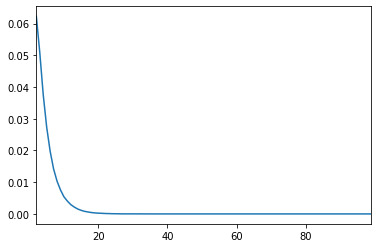

In [224]:
prob_series.plot()

<AxesSubplot:>

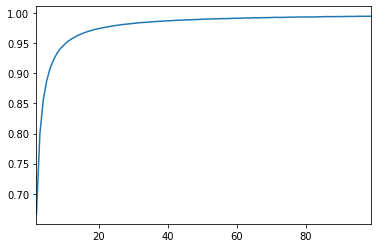

In [225]:
mean_series.plot()

# Find a sigmoid function that fit the mean values

In [226]:
def sigmoid(x, exponent, middle_x, amplitude, shift):
    return amplitude * ((x-shift)**exponent/((x-shift)**exponent + middle_x**exponent))

In [227]:
cards = mean_series.index.values
mean_values = mean_series.values

<AxesSubplot:>

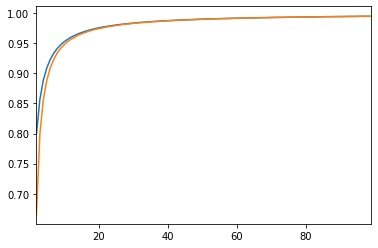

In [228]:
exponent, middle_x, amplitude, shift = 1, 0.5, 1, 0
plt.plot(cards, sigmoid(cards, exponent, middle_x, amplitude, shift))
mean_series.plot()

In [229]:
def loss(exponent, middle_x, amplitude, shift, cut_card=40):
    return ((sigmoid(cards[:cut_card], exponent, middle_x, amplitude, shift) - mean_values[:cut_card])**2).mean()

<AxesSubplot:>

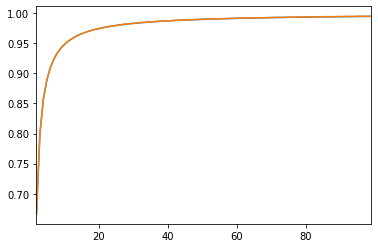

In [230]:
x0 = [exponent, middle_x, amplitude, shift]
result = minimize(lambda x: loss(x[0], x[1], x[2], x[3]), x0, method='Nelder-Mead', tol=1e-6)
exponent, middle_x, amplitude, shift = result.x
plt.plot(cards, sigmoid(cards, exponent, middle_x, amplitude, shift))
mean_series.plot()

In [237]:
np.round(np.array([exponent, middle_x, amplitude, shift]), 6)

array([1.012357, 0.513645, 0.999557, 0.980772])

We use this optimized parameters $\theta^*$ to define a normalized TV distance:
$$tv^*(p_1, p_2) = \frac{1}{\sigma(C; \theta^*)} \sum_{i=1}^C |p_1(i) - p_2(i)| $$

In [232]:
def normalization(card):
    return 1/sigmoid(card, exponent, middle_x, amplitude, shift)

def calc_norm_tv(p1, p2):
    return normalization(p1.shape[1]) * abs(p1 - p2).sum(axis=1)

In [233]:
card_range = np.arange(2, 100, dtype=int)
samples = 1_000_000
thresh = 1.5

prob_series = pd.Series({card: estimate_prob(card, thresh, calc_norm_tv) for card in card_range}, 
                        name=f'prob(tv > {thresh})')
mean_series = pd.Series({card: estimate_mean(card, calc_norm_tv) for card in card_range},
                        name='E(tv)')

<AxesSubplot:>

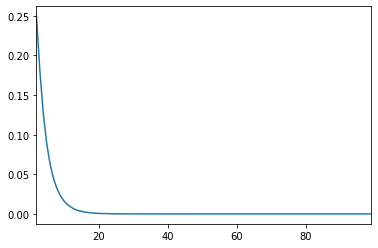

In [234]:
prob_series.plot()

<AxesSubplot:>

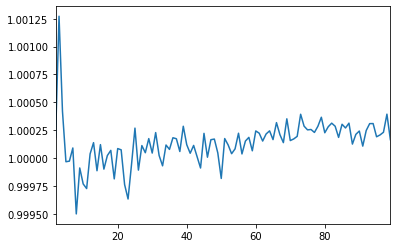

In [235]:
mean_series.plot()